In [75]:
import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Dropout, Input, Embedding, Flatten, Concatenate, Dense
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError, R2Score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Nadam

from Funcoes_Comuns import avaliar_modelo, registrar_modelo

In [8]:
# Definir a semente para reprodutibilidade
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

Recuperar base já pré-processada

In [9]:
# Obter dados
df_enem = pd.read_pickle('Bases\MICRODADOS_ENEM_2023_tratados.pkl')

In [10]:
df_enem.head()

,BIN_Q001_DUMMY_H,BIN_Q002_DUMMY_H,BIN_Q018,BIN_Q020,BIN_Q021,BIN_Q023,BIN_Q025,CAT_COR_RACA,CAT_CO_MUNICIPIO_ESC,CAT_CO_UF_ESC,...,NUM_Q011,NUM_Q012,NUM_Q013,NUM_Q014,NUM_Q015,NUM_Q016,NUM_Q017,NUM_Q019,NUM_Q022,NUM_Q024
0,False,False,False,False,False,False,True,3,2304400,23,...,0,1,0,0,0,0,0,1,3,0
1,False,False,False,False,False,False,False,3,2311306,23,...,0,1,0,0,0,0,0,1,1,0
2,False,False,False,False,False,False,True,3,4128005,41,...,0,1,0,1,0,0,0,1,1,1
3,False,False,False,False,False,True,True,1,1501402,15,...,0,1,0,0,0,0,0,1,3,0
4,False,False,False,False,False,False,True,1,3550308,35,...,0,1,0,1,0,0,0,1,1,0


Parâmetros

In [11]:
variaveis_alvo = ['NUM_NOTA_MT', 'NUM_NOTA_LC', 'NUM_NOTA_CN', 'NUM_NOTA_CH', 'NUM_NOTA_REDACAO']
grupo_previsao = ['NUM_NOTA_CH']

One-hot Encoding

In [12]:
# Remover CAT_CO_MUNICIPIO_ESC devido alta cardinalidade
df_enem = df_enem.drop(columns=['CAT_CO_MUNICIPIO_ESC'])

In [13]:
# Aplicar o OneHotEncoder para converter as colunas categóricas em variáveis dummy
categorical_columns = df_enem.select_dtypes(include=['category']).columns
df_enem = pd.get_dummies(df_enem, columns=categorical_columns, drop_first=True)

In [14]:
df_enem.head()

,BIN_Q001_DUMMY_H,BIN_Q002_DUMMY_H,BIN_Q018,BIN_Q020,BIN_Q021,BIN_Q023,BIN_Q025,NUM_NOTA_CH,NUM_NOTA_CN,NUM_NOTA_LC,...,CAT_Q003_F,CAT_Q004_B,CAT_Q004_C,CAT_Q004_D,CAT_Q004_E,CAT_Q004_F,CAT_SEXO_M,CAT_SIT_FUNC_ESC_2,CAT_SIT_FUNC_ESC_3,CAT_SIT_FUNC_ESC_4
0,False,False,False,False,False,False,True,508.5,459.0,507.2,...,False,True,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,379.2,402.5,446.9,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,True,667.6,608.2,607.9,...,False,True,False,False,False,False,True,False,False,False
3,False,False,False,False,False,True,True,553.1,515.7,544.4,...,False,True,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,True,576.3,523.8,596.5,...,False,True,False,False,False,False,True,False,False,False


In [15]:
# separar em treino e teste
X = df_enem.drop(columns=variaveis_alvo)
y = df_enem[grupo_previsao]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [16]:
# Criar grupo de validação (15% do conjunto de treino)
X_train, X_eval, y_train, y_eval = train_test_split(
    X_train,
    y_train,
    test_size=0.15,
    random_state=42
)

Normalização -> Testar StandardScaler (melhor) e MinMaxScaler

In [17]:
# Identificar colunas booleanas e outras
bool_cols_X = X_train.select_dtypes(include=['bool']).columns
num_cols_X = X_train.select_dtypes(include=[np.number]).columns.difference(bool_cols_X)

In [18]:
X_train

,BIN_Q001_DUMMY_H,BIN_Q002_DUMMY_H,BIN_Q018,BIN_Q020,BIN_Q021,BIN_Q023,BIN_Q025,NUM_Q001,NUM_Q002,NUM_Q005,...,CAT_Q003_F,CAT_Q004_B,CAT_Q004_C,CAT_Q004_D,CAT_Q004_E,CAT_Q004_F,CAT_SEXO_M,CAT_SIT_FUNC_ESC_2,CAT_SIT_FUNC_ESC_3,CAT_SIT_FUNC_ESC_4
713684,True,True,False,False,False,False,True,4,4,5,...,True,False,False,False,False,True,True,False,False,False
518205,False,False,False,False,True,False,True,3,3,4,...,False,True,False,False,False,False,True,False,False,False
207306,False,False,False,False,False,False,True,3,4,4,...,True,False,False,False,False,True,True,False,False,False
469659,False,False,True,True,True,False,True,4,4,4,...,False,True,False,False,False,False,True,False,False,False
140617,False,False,False,False,False,False,True,2,2,6,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329019,False,False,False,True,True,False,True,2,4,3,...,False,True,False,False,False,False,True,False,False,False
251563,False,False,False,True,True,False,True,6,5,4,...,False,False,False,True,False,False,False,False,False,False
359279,False,False,True,False,True,True,True,6,5,2,...,False,False,False,False,True,False,False,False,False,False
570727,False,False,True,True,True,True,True,5,5,4,...,False,False,False,True,False,False,False,False,False,False


In [19]:
# Normalizar X - Referencia apenas cunjunto de treino
X_scaler = StandardScaler()
X_train[num_cols_X] = X_scaler.fit_transform(X_train[num_cols_X])
X_eval[num_cols_X] = X_scaler.transform(X_eval[num_cols_X])
X_test[num_cols_X] = X_scaler.transform(X_test[num_cols_X])

# Normalizar y - Referencia apenas cunjunto de treino (não há colunas booleanas)
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train)
y_eval = y_scaler.transform(y_eval)
y_test = y_scaler.transform(y_test)

In [20]:
# Converter dados para modelo - redes neurais esperam dados em numpy arrays
X_train = X_train.astype(np.float32)
X_eval = X_eval.astype(np.float32)
X_test = X_test.astype(np.float32)

y_train = y_train.astype(np.float32)
y_eval = y_eval.astype(np.float32)
y_test = y_test.astype(np.float32)

Modelo base (sem variável CAT_CO_MUNICIPIO_ESC devido alta dimensionalidade do One-Hot)

In [21]:
# Construir a rede neural com 5 camadas
model = Sequential([
    Input(shape=(X_train.shape[1],)),                      # Camada de entrada
    Dense(64, activation='relu'),                          # Camada oculta 1
    Dense(32, activation='relu'),                          # Camada oculta 2
    Dense(16, activation='relu'),                          # Camada oculta 3
    Dense(8, activation='relu'),                           # Camada oculta 4
    Dense(units=len(grupo_previsao), activation='linear')  # Camada de saída para regressão: 1 variável, ativação linear
])

In [22]:
# Compilar o modelo
model.compile(
    optimizer='adam',
    loss='mse',        # Função de perda
    metrics=[MeanAbsoluteError(), RootMeanSquaredError(), R2Score()]
)

In [23]:
# Resumo do modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         6,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,601 (37.50 KB)

 Trainable params: 9,601 (37.50 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Treinar o modelo
early_stopping = EarlyStopping(
    monitor='val_loss',           # Monitorar a perda no conjunto de validação
    patience=5,                   # Parar após n épocas sem melhoria
    mode='min',                   # Minimizar a perda
    restore_best_weights=True     # Restaurar os melhores pesos encontrados
)

In [25]:
history = model.fit(
    X_train, 
    y_train,
    validation_data=(X_eval, y_eval),    # Usar o conjunto validação
    epochs=50,                           # Número máximo de épocas
    batch_size=256,                      # Tamanho do batch
    callbacks=[early_stopping],          # Usar early stopping
    verbose=1
)

Epoch 1/50
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.7344 - mean_absolute_error: 0.6769 - r2_score: 0.2647 - root_mean_squared_error: 0.8566 - val_loss: 0.6996 - val_mean_absolute_error: 0.6572 - val_r2_score: 0.3000 - val_root_mean_squared_error: 0.8364
Epoch 2/50
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6933 - mean_absolute_error: 0.6566 - r2_score: 0.3059 - root_mean_squared_error: 0.8326 - val_loss: 0.6953 - val_mean_absolute_error: 0.6552 - val_r2_score: 0.3043 - val_root_mean_squared_error: 0.8339
Epoch 3/50
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6897 - mean_absolute_error: 0.6546 - r2_score: 0.3095 - root_mean_squared_error: 0.8305 - val_loss: 0.6944 - val_mean_absolute_error: 0.6542 - val_r2_score: 0.3052 - val_root_mean_squared_error: 0.8333
Epoch 4/50
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.6875 - mean_absolute_error: 0.6534 - r2_score: 0.3117 - root_mean_squared_error: 0.8292 - val_loss: 0.6942 - val_mean_absolute_error: 0.65

In [26]:
# Avaliar o modelo no conjunto de teste
model.evaluate(X_test, y_test, verbose=1)

4479/4479 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.6917 - mean_absolute_error: 0.6522 - r2_score: 0.3078 - root_mean_squared_error: 0.8316


[0.693010687828064, 0.653452455997467, 0.8324726223945618, 0.30544954538345337]

    Com uso de one-hot
    Impossível com o hardware atual

    Com uso de one-hot encoder sem Código do Municipio (Possui mais de 5000 categorias)
    [50.6934848427772522, 0.6552520394325256, 0.8327573537826538, 0.304974317550659]

In [27]:
# Previsões
y_pred = model.predict(X_test)

4479/4479 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


In [28]:
# Desnormalizar
y_test_desnorm = y_scaler.inverse_transform(y_test)
y_pred_desnorm = y_scaler.inverse_transform(y_pred)

In [31]:
# Avaliação grupo treino
avaliar_modelo(y_scaler.inverse_transform(y_train),
               y_scaler.inverse_transform(model.predict(X_train)), 
               "treino")

# Avaliação grupo teste
avaliar_modelo(y_test_desnorm,
               y_pred_desnorm,
               "teste")

15228/15228 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step
MAE (treino): 54.99
RMSE (treino): 70.07
R2 (treino): 0.31
MAE (teste): 55.30
RMSE (teste): 70.46
R2 (teste): 0.31


In [295]:
# Salvar o modelo otimizado como um arquivo pickle
joblib.dump(model, 'Modelos\modelo_RNA_base.pkl')

['Modelos\\modelo_RNA_base.pkl']

Testar Embedding para coluna CO_MUNICIPIO_ESC

In [32]:
# Obter dados
df_enem = pd.read_pickle('Bases\MICRODADOS_ENEM_2023_tratados.pkl')

In [33]:
# 1. Separar a coluna de alta cardinalidade
municipio_col = 'CAT_CO_MUNICIPIO_ESC'
municipios = df_enem[municipio_col].astype(str)  # garantir string para LabelEncoder
X_features = df_enem.drop(columns=[municipio_col] + variaveis_alvo)

In [34]:
# 2. Codificar a coluna como inteiros
le_municipio = LabelEncoder()
municipios_encoded = le_municipio.fit_transform(municipios)

In [35]:
# 3. One-hot para as demais features
categorical_columns = X_features.select_dtypes(include=['category']).columns
X_features = pd.get_dummies(X_features, columns=categorical_columns, drop_first=True)

    f: features
    m: municipios

In [36]:
# 4. Separar treino/teste/validação para ambos
X_train_f, X_test_f, X_train_m, X_test_m, y_train, y_test = train_test_split(
    X_features, municipios_encoded, df_enem[grupo_previsao], test_size=0.2, random_state=seed
)
X_train_f, X_eval_f, X_train_m, X_eval_m, y_train, y_eval = train_test_split(
    X_train_f, X_train_m, y_train, test_size=0.15, random_state=seed
)

In [37]:
# 5. Normalizar demais features e y
# Normalizar X - Referencia apenas cunjunto de treino
X_scaler = StandardScaler()
X_train_f = X_scaler.fit_transform(X_train_f)
X_eval_f = X_scaler.transform(X_eval_f)
X_test_f = X_scaler.transform(X_test_f)

# Normalizar y - Referencia apenas cunjunto de treino (não há colunas booleanas)
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train)
y_eval = y_scaler.transform(y_eval)
y_test = y_scaler.transform(y_test)

In [38]:
# 6. Converter dados para modelo - redes neurais esperam dados em numpy arrays
X_train_f = X_train_f.astype(np.float32)
X_eval_f = X_eval_f.astype(np.float32)
X_test_f = X_test_f.astype(np.float32)

y_train = y_train.astype(np.float32)
y_eval = y_eval.astype(np.float32)
y_test = y_test.astype(np.float32)

In [39]:
# 7. Modelo funcional com embedding

# Inputs
input_features = Input(shape=(X_train_f.shape[1],), name='features')
input_municipio = Input(shape=(1,), name='municipio')

In [40]:
# Embedding
n_municipios = len(le_municipio.classes_)
embedding_dim = 16  # escolha um valor pequeno, ex: 8~32
x_municipio = Embedding(input_dim=n_municipios, output_dim=embedding_dim)(input_municipio)
x_municipio = Flatten()(x_municipio)

In [41]:
# Concatenar
x = Concatenate()([input_features, x_municipio])

In [42]:
# Camadas densas
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dense(8, activation='relu')(x)
output = Dense(len(grupo_previsao), activation='linear')(x)

model_embedding = Model(inputs=[input_features, input_municipio], outputs=output)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',           # Monitorar a perda no conjunto de validação
    patience=5,                   # Parar após n épocas sem melhoria
    mode='min',                   # Minimizar a perda
    restore_best_weights=True     # Restaurar os melhores pesos encontrados
)

In [43]:
# Compilar e treinar
model_embedding.compile(
    optimizer='adam',
    loss='mse',
    metrics=[MeanAbsoluteError(), RootMeanSquaredError(), R2Score()]
)

In [44]:
history = model_embedding.fit(
    [X_train_f, X_train_m], y_train,
    validation_data=([X_eval_f, X_eval_m], y_eval),
    epochs=50,
    batch_size=256,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.7308 - mean_absolute_error: 0.6759 - r2_score: 0.2684 - root_mean_squared_error: 0.8546 - val_loss: 0.6946 - val_mean_absolute_error: 0.6554 - val_r2_score: 0.3051 - val_root_mean_squared_error: 0.8334
Epoch 2/50
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.6833 - mean_absolute_error: 0.6511 - r2_score: 0.3159 - root_mean_squared_error: 0.8266 - val_loss: 0.6911 - val_mean_absolute_error: 0.6537 - val_r2_score: 0.3085 - val_root_mean_squared_error: 0.8313
Epoch 3/50
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.6763 - mean_absolute_error: 0.6474 - r2_score: 0.3229 - root_mean_squared_error: 0.8224 - val_loss: 0.6902 - val_mean_absolute_error: 0.6534 - val_r2_score: 0.3094 - val_root_mean_squared_error: 0.8308
Epoch 4/50
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.6715 - mean_absolute_error: 0.6448 - r2_score: 0.3277 - root_mean_squared_error: 0.8194 - val_loss: 0.6904 - val_mean_absolute_error: 0.6

In [45]:
# Avaliar o modelo no conjunto de teste
model_embedding.evaluate([X_test_f, X_test_m], y_test, verbose=1)

4479/4479 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.6877 - mean_absolute_error: 0.6512 - r2_score: 0.3117 - root_mean_squared_error: 0.8293


[0.6895506978034973,
 0.6525660157203674,
 0.8303918838500977,
 0.30891722440719604]

In [46]:
# Previsões
y_pred = model_embedding.predict([X_test_f, X_test_m])

4479/4479 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


In [47]:
# Desnormalizar
y_test_desnorm = y_scaler.inverse_transform(y_test)
y_pred_desnorm = y_scaler.inverse_transform(y_pred)

In [48]:
# Avaliação grupo treino
avaliar_modelo(y_scaler.inverse_transform(y_train),
               y_scaler.inverse_transform(model_embedding.predict([X_train_f, X_train_m])), 
               "treino")

# Avaliação grupo teste
avaliar_modelo(y_test_desnorm,
               y_pred_desnorm,
               "teste")

15228/15228 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step
MAE (treino): 54.34
RMSE (treino): 69.25
R2 (treino): 0.33
MAE (teste): 55.23
RMSE (teste): 70.28
R2 (teste): 0.31


In [314]:
# Salvar o modelo otimizado como um arquivo pickle
joblib.dump(model_embedding, 'Modelos\modelo_RNA_base_embedding.pkl')

['Modelos\\modelo_RNA_base_embedding.pkl']

    Modelo com Embedding se saiu melhor

    Indica que o município da escola importa
    
    Bom sinal para inclusão dos dados do censo que detalham mais as características da escola de cada município

Deixar modelo mais elaborado: parametros melhores, camadas

    Utilizar otimizador Nadam
    Mudar learning rate
    Aumementar camadas
    Reduzir Batch size
    Aumentar patience (early stopping)

In [83]:
# Inputs
input_features = Input(shape=(X_train_f.shape[1],), name='features')
input_municipio = Input(shape=(1,), name='municipio')

# Embedding
n_municipios = len(le_municipio.classes_)
embedding_dim = 16  # escolha um valor pequeno, ex: 8~32
x_municipio = Embedding(input_dim=n_municipios, output_dim=embedding_dim)(input_municipio)
x_municipio = Flatten()(x_municipio)

# Concatenar
x = Concatenate()([input_features, x_municipio])

In [84]:
# Camadas densas
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dense(8, activation='relu')(x)
output = Dense(len(grupo_previsao), activation='linear')(x)

model_emb_param = Model(inputs=[input_features, input_municipio], outputs=output)

In [85]:
# Parametros de parada
early_stopping = EarlyStopping(
    monitor='val_loss',           # Monitorar a perda no conjunto de validação
    patience=10,                  # Parar após n épocas sem melhoria
    mode='min',                   # Minimizar a perda
    restore_best_weights=True     # Restaurar os melhores pesos encontrados
)

# Compilar e treinar
model_emb_param.compile(
    optimizer=Nadam(learning_rate=0.001),
    loss='mse',
    metrics=[MeanAbsoluteError(), RootMeanSquaredError(), R2Score()]
)

In [86]:
history = model_emb_param.fit(
    [X_train_f, X_train_m], y_train,
    validation_data=([X_eval_f, X_eval_m], y_eval),
    epochs=50,
    batch_size=128,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - loss: 0.7178 - mean_absolute_error: 0.6692 - r2_score: 0.2814 - root_mean_squared_error: 0.8470 - val_loss: 0.6900 - val_mean_absolute_error: 0.6537 - val_r2_score: 0.3097 - val_root_mean_squared_error: 0.8306
Epoch 2/50
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.6816 - mean_absolute_error: 0.6501 - r2_score: 0.3176 - root_mean_squared_error: 0.8256 - val_loss: 0.6877 - val_mean_absolute_error: 0.6528 - val_r2_score: 0.3119 - val_root_mean_squared_error: 0.8293
Epoch 3/50
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.6748 - mean_absolute_error: 0.6465 - r2_score: 0.3244 - root_mean_squared_error: 0.8215 - val_loss: 0.6877 - val_mean_absolute_error: 0.6528 - val_r2_score: 0.3119 - val_root_mean_squared_error: 0.8293
Epoch 4/50
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.6697 - mean_absolute_error: 0.6438 - r2_score: 0.3295 - root_mean_squared_error: 0.8184 - val_loss: 0.6883 - val_mean_absolute_error: 

In [87]:
# Avaliar o modelo no conjunto de teste
model_emb_param.evaluate([X_test_f, X_test_m], y_test, verbose=1)

4479/4479 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.6856 - mean_absolute_error: 0.6508 - r2_score: 0.3138 - root_mean_squared_error: 0.8280


[0.6871399283409119,
 0.6519883275032043,
 0.8289390206336975,
 0.3113332986831665]

In [88]:
# Previsões
y_pred = model_emb_param.predict([X_test_f, X_test_m])

# Desnormalizar
y_test_desnorm = y_scaler.inverse_transform(y_test)
y_pred_desnorm = y_scaler.inverse_transform(y_pred)

# Avaliação grupo treino
avaliar_modelo(y_scaler.inverse_transform(y_train),
               y_scaler.inverse_transform(model_emb_param.predict([X_train_f, X_train_m])), 
               "treino")

# Avaliação grupo teste
avaliar_modelo(y_test_desnorm,
               y_pred_desnorm,
               "teste")

4479/4479 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
15228/15228 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step
MAE (treino): 54.51
RMSE (treino): 69.37
R2 (treino): 0.33
MAE (teste): 55.18
RMSE (teste): 70.16
R2 (teste): 0.31


Aplicar Dropout e BatchNormalization no modelo base

In [144]:
# Modelo com Embedding, Dropout e BatchNormalization

# Inputs
input_features = Input(shape=(X_train_f.shape[1],), name='features')
input_municipio = Input(shape=(1,), name='municipio')

# Embedding
n_municipios = len(le_municipio.classes_)
embedding_dim = 16  # escolha um valor pequeno, ex: 8~32
x_municipio = Embedding(input_dim=n_municipios, output_dim=embedding_dim)(input_municipio)
x_municipio = Flatten()(x_municipio)

# Concatenar
x = Concatenate()([input_features, x_municipio])

In [157]:
# Camadas densas
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dense(8, activation='relu')(x)
output = Dense(len(grupo_previsao), activation='linear')(x)

model_emb_drop_bat = Model(inputs=[input_features, input_municipio], outputs=output)

In [159]:
# Parametros de parada
early_stopping = EarlyStopping(
    monitor='val_loss',           # Monitorar a perda no conjunto de validação
    patience=10,                  # Parar após n épocas sem melhoria
    mode='min',                   # Minimizar a perda
    restore_best_weights=True     # Restaurar os melhores pesos encontrados
)

# Compilar e treinar
model_emb_drop_bat.compile(
    optimizer=Nadam(learning_rate=0.0005),
    loss='mse',
    metrics=[MeanAbsoluteError(), RootMeanSquaredError(), R2Score()]
)

In [160]:
history = model_emb_drop_bat.fit(
    [X_train_f, X_train_m], y_train,
    validation_data=([X_eval_f, X_eval_m], y_eval),
    epochs=50,
    batch_size=512,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
952/952 ━━━━━━━━━━━━━━━━━━━━ 29s 20ms/step - loss: 0.7523 - mean_absolute_error: 0.6878 - r2_score: 0.2467 - root_mean_squared_error: 0.8666 - val_loss: 0.6915 - val_mean_absolute_error: 0.6582 - val_r2_score: 0.3081 - val_root_mean_squared_error: 0.8316
Epoch 2/50
952/952 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - loss: 0.6831 - mean_absolute_error: 0.6517 - r2_score: 0.3160 - root_mean_squared_error: 0.8265 - val_loss: 0.6920 - val_mean_absolute_error: 0.6573 - val_r2_score: 0.3077 - val_root_mean_squared_error: 0.8319
Epoch 3/50
952/952 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - loss: 0.6794 - mean_absolute_error: 0.6497 - r2_score: 0.3198 - root_mean_squared_error: 0.8243 - val_loss: 0.6913 - val_mean_absolute_error: 0.6574 - val_r2_score: 0.3084 - val_root_mean_squared_error: 0.8314
Epoch 4/50
952/952 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - loss: 0.6773 - mean_absolute_error: 0.6485 - r2_score: 0.3218 - root_mean_squared_error: 0.8230 - val_loss: 0.6908 - val_mean_absolute_error: 0.65

In [161]:
# Avaliar o modelo no conjunto de teste
model_emb_drop_bat.evaluate([X_test_f, X_test_m], y_test, verbose=1)

4479/4479 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.6890 - mean_absolute_error: 0.6559 - r2_score: 0.3105 - root_mean_squared_error: 0.8300


[0.6903371810913086,
 0.6570842266082764,
 0.8308653235435486,
 0.3081289529800415]

In [162]:
# Previsões
y_pred = model_emb_drop_bat.predict([X_test_f, X_test_m])

# Desnormalizar
y_test_desnorm = y_scaler.inverse_transform(y_test)
y_pred_desnorm = y_scaler.inverse_transform(y_pred)

# Avaliação grupo treino
avaliar_modelo(y_scaler.inverse_transform(y_train),
               y_scaler.inverse_transform(model_emb_drop_bat.predict([X_train_f, X_train_m])), 
               "treino")

# Avaliação grupo teste
avaliar_modelo(y_test_desnorm,
               y_pred_desnorm,
               "teste")

4479/4479 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
15228/15228 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step
MAE (treino): 54.45
RMSE (treino): 68.95
R2 (treino): 0.34
MAE (teste): 55.61
RMSE (teste): 70.32
R2 (teste): 0.31


In [163]:
# Salvar o modelo otimizado como um arquivo pickle
joblib.dump(model_emb_drop_bat, 'Modelos\modelo_RNA_base_embedding_dropout_batchnorm.pkl')

['Modelos\\modelo_RNA_base_embedding_dropout_batchnorm.pkl']

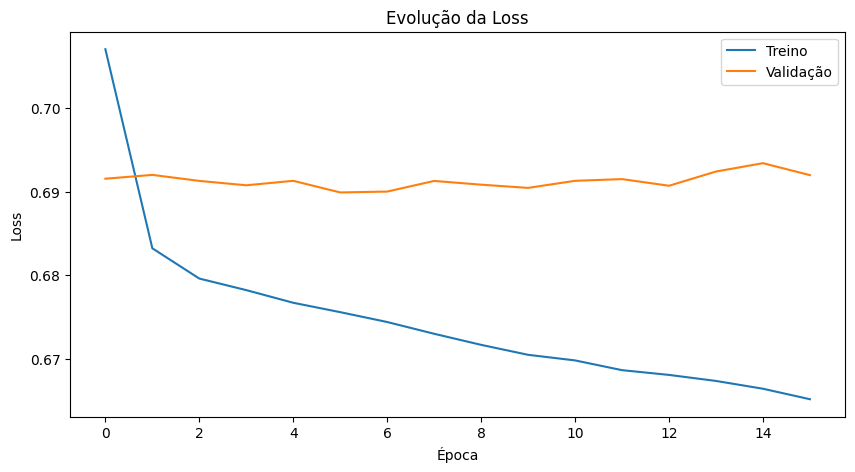

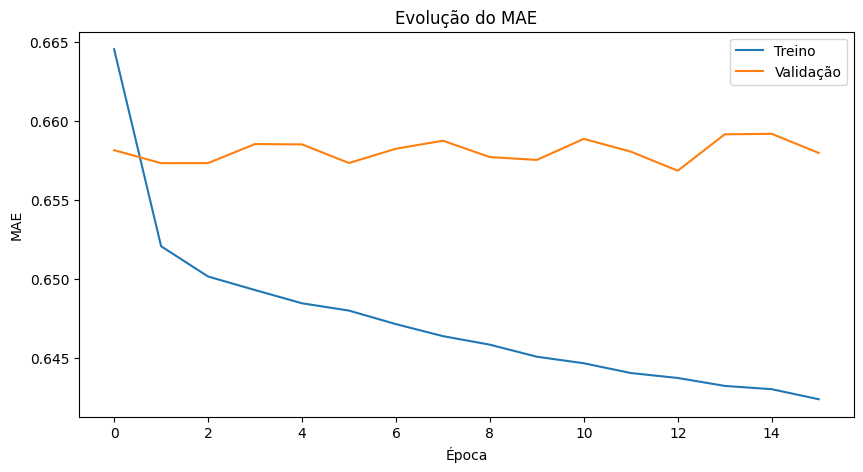

In [164]:
import matplotlib.pyplot as plt

# Exemplo para a métrica de perda (loss)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Evolução da Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Para outras métricas, basta trocar 'loss' por 'mean_absolute_error', 'root_mean_squared_error', etc.
# Exemplo para MAE:
plt.figure(figsize=(10, 5))
plt.plot(history.history['mean_absolute_error'], label='Treino')
plt.plot(history.history['val_mean_absolute_error'], label='Validação')
plt.title('Evolução do MAE')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.show()